# Coding Discussion 06


In [50]:
#importing packages
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [51]:
#reading in training and test data
train=pd.read_csv("/Users/carolineadams/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
test=pd.read_csv("/Users/carolineadams/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")

## Preparing Training Data

<AxesSubplot:>

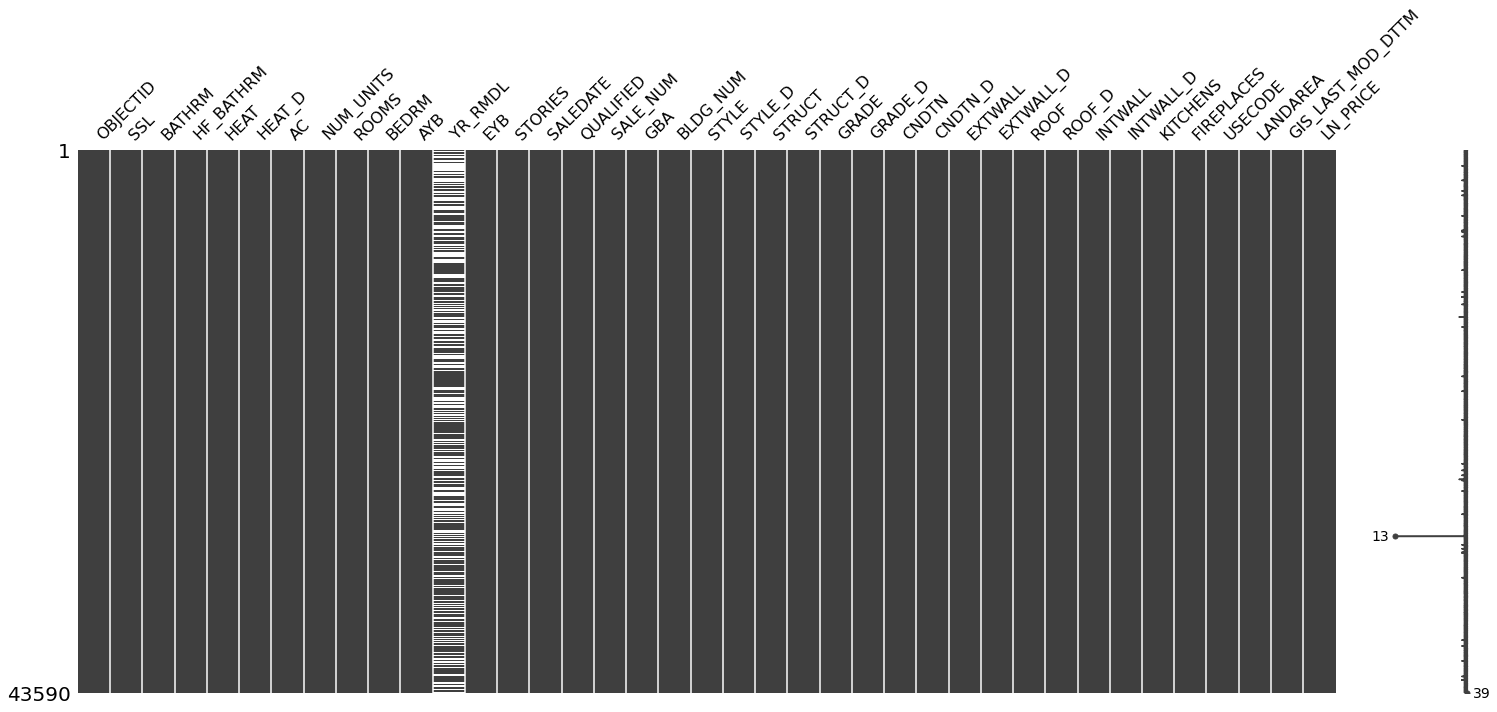

In [52]:
#check for missing data
miss.matrix(train)

In [53]:
#remove missing values where outcome is missing
train=train[-train.LN_PRICE.isna()]

#only keep observations when there is a selling price
train = train[train.LN_PRICE > 0]

In [54]:
#drop all other remaining NA values
train.dropna(inplace=True)

In [55]:
#setting outcome variable
train_y = train['LN_PRICE']
#setting the predictor variables
train_x = train[["BATHRM", "HF_BATHRM", "BEDRM", "ROOMS", "FIREPLACES", "STORIES"]]

In [56]:
#examine the first rows of the training predictor variables
train_x.head()

,BATHRM,HF_BATHRM,BEDRM,ROOMS,FIREPLACES,STORIES
0,3.0,1.0,4.0,9.0,0.0,2.00
2,2.0,2.0,4.0,9.0,1.0,2.50
4,2.0,0.0,4.0,11.0,0.0,2.00
6,3.0,0.0,4.0,7.0,1.0,1.75
7,3.0,1.0,3.0,7.0,0.0,2.00


In [57]:
#look at shape of predictor variables
train_x.shape

(24996, 6)

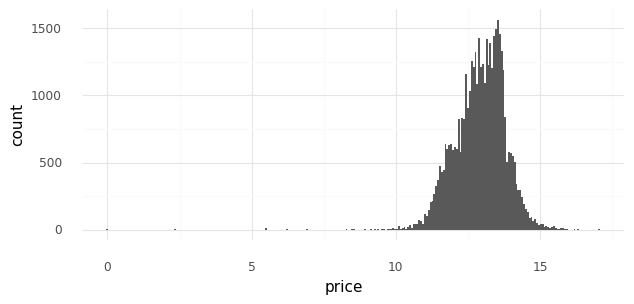

<ggplot: (8774800932063)>

In [9]:
#examine how outcome variable is distributed
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

## Creating Modeling Pipeline

In [40]:
#set up modeling pipeline

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
#rescale training data
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["BATHRM", "HF_BATHRM", "BEDRM", "ROOMS", "STORIES", "FIREPLACES"])])

# (3) create model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'HF_BATHRM',
                                                                          'BEDRM',
                                                                          'ROOMS',
                                                                          'STORIES',
                                                                          'FIREPLACES'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor

In [41]:
# Mean out-of-sample (CV) error; the best fit score
search.best_score_

-0.38058810549163297

In [42]:
#identify the best model
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

## Running model on test data

In [45]:
#remove missing values from test data where outcome is missing
test=test[-test.LN_PRICE.isna()]

#only keep observations when there is a selling price
test = test[test.LN_PRICE > 0]

#drop all other remaining NA values
test.dropna(inplace=True)

#setting outcome variable
test_y = test['LN_PRICE']
#setting the predictor variables
test_x = test[["BATHRM", "HF_BATHRM", "BEDRM", "ROOMS", "FIREPLACES", "STORIES"]]

In [46]:
# Predict() method to use the best model on the test data
pred_y = search.predict(test_x)

In [47]:
#calculate the mean squared error on the test data
m.mean_squared_error(test_y,pred_y)

0.3742546956669257

In [48]:
#calculate the R2 value of the best fitting model on the test data
m.r2_score(test_y,pred_y)

0.3824231501607862

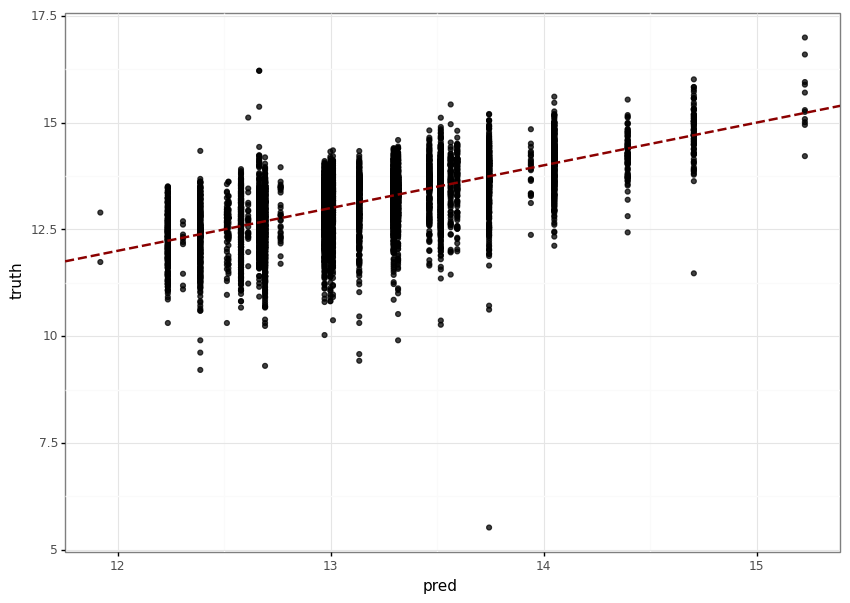

<ggplot: (8774800599763)>

In [49]:
#plot the predictions from the best model against the true values of the test data
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Conclusions
Out of the five models tested, the decision tree regressor with a max depth of 5 was the best fit on the training data. It resulted in a mean squared error of 0.38. When this model was run on the test data, the mean squared error was slightly reduced to 0.37. The R squared value on the test data was 0.38, meaning that the best fitting model only explained approximately 38% of the variation in the relationship between the predictor variables included in the model and the log price of the homes that were sold. This means that although it was the best model of those run on the training data, it had a predictive accuracy less than 50%.